In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from torch.utils.data import Dataset
from copy import deepcopy
from scipy import integrate

In [3]:
class FitzhughNagumo(Dataset):
    def __init__(self, N, T, I=0.5, a=0.7, b=0.8):
        self.I = I
        self.a = a
        self.b = b
        self.N = N
        self.T = T

        data_x = []
        data_y = []
        for i in range(N):
            t = np.linspace(0,400,T+1)
            x0 = np.array([float(np.random.rand(1))*2.-1.,0.])
            sol = integrate.solve_ivp(self.FHN_rhs, [0,400], x0, t_eval=t)
            data_x.append(sol.y[0,:-1])
            data_y.append(sol.y[0,1:])

        self.data_x = np.array(data_x).reshape(N,T,1)
        self.data_y = np.array(data_y).reshape(N,T,1)

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        return torch.Tensor(self.data_x[idx]), torch.Tensor(self.data_y[idx])

    def FHN_rhs(self, t,x):
        I, a, b = self.I, self.a, self.b
        eps = 1./50.
        dim1 = x[0] - (x[0]**3)/3. - x[1] + I
        dim2 = eps*(x[0] + a - b*x[1])
        out = np.stack((dim1,dim2)).T

        return out

    def get_init(self):
        t = np.linspace(0,400,self.T+1)
        x0 = np.array([float(np.random.rand(1))*2.-1.,0.])
        sol = integrate.solve_ivp(self.FHN_rhs, [0,400], x0, t_eval=t)
        init_x = sol.y[0, :50]
        return init_x

In [7]:
class torchGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(torchGRU, self).__init__()
        self.rnn = nn.GRU(input_size,
                          hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
 
    def forward(self, seq, hc=None):
        tmp, hc = self.rnn(seq, hc)
        out = self.linear(tmp)
        return out

In [4]:
def train_model(model, dataset, params, visualize_train=True):

    # create the data generator to iterate over mini batches
    trainDataGenerator = torch.utils.data.DataLoader(dataset, **params['train_params'])

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['init_lr'])

    if visualize_train:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for epoch in range(params['num_epochs']):

        for data, label in trainDataGenerator:
            # The inputs need to be of the form T x B x N_in
            # where T is the total "time" duration of the signal, B is the batch size
            # and N_in is the feature dimensionality of an observation
            data = data.transpose(0, 1) #.to('cuda:0')

            # forward pass
            readout = model(data)

            # compute the loss
            loss = criterion(readout.permute(1,0,-1), label)

            # backpropagate through time!
            loss.backward()

            # update model parameters
            optimizer.step()
            optimizer.zero_grad()
            
            if visualize_train:
                ax.clear()
                # Let's pick index 0, since batch is shuffled anyway!
                ax.plot(data[:,0,0].detach().numpy(), linewidth=2, color='tab:gray', label='groundtruth')
                ax.plot(readout[:,0,0].detach().numpy(), '--', linewidth=2, color='r', label='prediction')

                # Just formatting options. This is my pet peeve so you can safely ignore!
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_title('Training epoch: {}'.format(epoch))
                ax.set_xlabel('Time', fontsize=16, fontweight='bold')
                ax.set_ylabel('Firing rate (in a.u.)', fontsize=16, fontweight='bold')
                ax.legend(loc='upper right')
                ax.set_xticks([0., data.shape[0]])
                ax.set_xticklabels(['0ms', '{}ms'.format(data.shape[0])])
                ax.set_yticks([])
                ax.set_ylim([-2.5, 2.5]) 
                
                plt.pause(0.1)

        print('Epoch: {} | Training Loss: {}'.format(epoch, loss.item()))

    return model

In [5]:
fhDataset = FitzhughNagumo(N=128, T=1000)

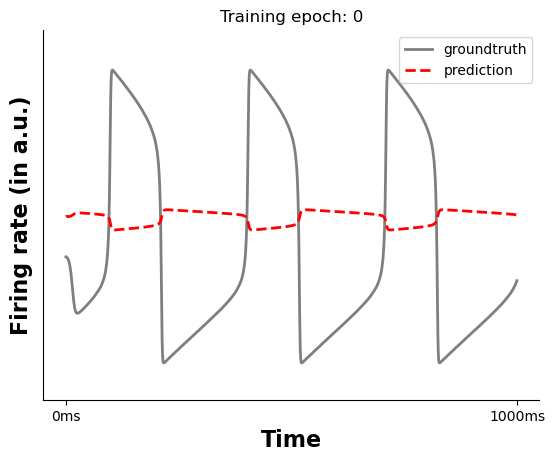

Epoch: 0 | Training Loss: 2.5399088859558105
Epoch: 1 | Training Loss: 2.1423985958099365
Epoch: 2 | Training Loss: 1.7816667556762695
Epoch: 3 | Training Loss: 1.439042568206787
Epoch: 4 | Training Loss: 1.0921909809112549
Epoch: 5 | Training Loss: 0.7344269156455994
Epoch: 6 | Training Loss: 0.4308088421821594
Epoch: 7 | Training Loss: 0.3009883463382721
Epoch: 8 | Training Loss: 0.26612263917922974
Epoch: 9 | Training Loss: 0.20558129251003265
Epoch: 10 | Training Loss: 0.15080669522285461
Epoch: 11 | Training Loss: 0.1654311865568161
Epoch: 12 | Training Loss: 0.19912318885326385
Epoch: 13 | Training Loss: 0.1893819123506546
Epoch: 14 | Training Loss: 0.1444680094718933
Epoch: 15 | Training Loss: 0.0920221209526062
Epoch: 16 | Training Loss: 0.05338522046804428
Epoch: 17 | Training Loss: 0.038027323782444
Epoch: 18 | Training Loss: 0.042576052248477936
Epoch: 19 | Training Loss: 0.05479766055941582
Epoch: 20 | Training Loss: 0.06255234032869339
Epoch: 21 | Training Loss: 0.06123292

In [8]:
params = {
        'n_inputs': 1,
        'n_hidden': 32,
        'num_epochs': 50,
        'init_lr': 1e-2,
        'n_outputs': 1,

        'train_params': {
                    'batch_size': 128,
                    'shuffle': True,
                    'num_workers': 1
                }
    }

# initialize the model architecture and set it to train mode
model = torchGRU(params['n_inputs'], params['n_hidden'], params['n_outputs'])
model = model.train()

# Now let's train the model. 
# Pass visualize_train=False to suppress any display
model = train_model(model, fhDataset, params)